In [4]:
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import snapatac2 as snap
import numpy as np
import pandas as pd
import os
import scanpy.external as sce
#adata_concat = snap.read_dataset('output/motif/motif/motif/motif/motif/mouse_brain.h5ads')

In [5]:
file = "/data2st1/junyi/output/mouse_brain_dar.h5ad"

In [6]:
adata = anndata.read_h5ad(file)

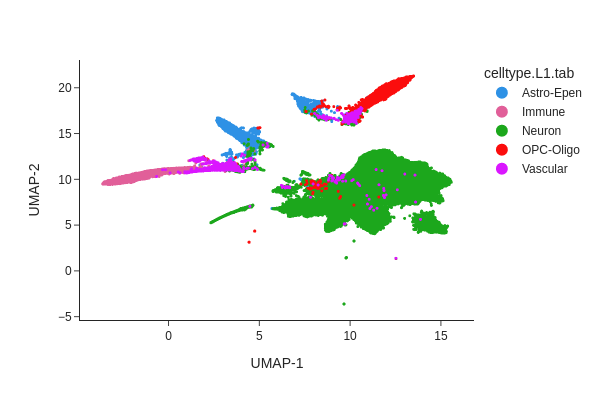

In [7]:
snap.pl.umap(adata, color="celltype.L1.tab", interactive=False,  marker_size=3)


In [8]:
df_meta = pd.read_csv("/data2st1/junyi/output/ATAC.3regions.MetaData.labelled.csv.gz", index_col=0, compression='gzip')

In [9]:
adata.obs

,sample,sample_barcode,obs_names,celltype.L2.p,celltype.L1.p,leiden,celltype.L1.GBoost,celltype.L1.tab,celltype.L1.new
MC50B_AMY_p40:AAACGAAAGAGTCCGA-1,MC50B_AMY_p40,MC50B_AMY_p40:AAACGAAAGAGTCCGA-1,/data8/hannan/data/snATAC_process/snATAC_01_ba...,Unknown,Unknown,4,Neuron,Neuron,Neuron
MC50B_AMY_p40:AAACGAAAGCAACGGT-1,MC50B_AMY_p40,MC50B_AMY_p40:AAACGAAAGCAACGGT-1,/data8/hannan/data/snATAC_process/snATAC_01_ba...,Unknown,Unknown,3,Neuron,Neuron,Neuron
MC50B_AMY_p40:AAACGAAAGCTACGTT-1,MC50B_AMY_p40,MC50B_AMY_p40:AAACGAAAGCTACGTT-1,/data8/hannan/data/snATAC_process/snATAC_01_ba...,Unknown,Unknown,3,Neuron,Neuron,Neuron
MC50B_AMY_p40:AAACGAAAGCTGAATA-1,MC50B_AMY_p40,MC50B_AMY_p40:AAACGAAAGCTGAATA-1,/data8/hannan/data/snATAC_process/snATAC_01_ba...,Unknown,Unknown,0,Neuron,Neuron,Neuron
MC50B_AMY_p40:AAACGAAAGGTCTTGT-1,MC50B_AMY_p40,MC50B_AMY_p40:AAACGAAAGGTCTTGT-1,/data8/hannan/data/snATAC_process/snATAC_01_ba...,Unknown,Unknown,4,Unknown,Neuron,Neuron
...,...,...,...,...,...,...,...,...,...
WT_W26_0_2_Perfrontal:TTTGTGTTCCAACAAC-1,WT_W26_0_2_Perfrontal,WT_W26_0_2_Perfrontal:TTTGTGTTCCAACAAC-1,/data8/hannan/data/snATAC_process/snATAC_01_ba...,MOL,OPC-Oligo,6,Neuron,OPC-Oligo,OPC-Oligo
WT_W26_0_2_Perfrontal:TTTGTGTTCCGTACGG-1,WT_W26_0_2_Perfrontal,WT_W26_0_2_Perfrontal:TTTGTGTTCCGTACGG-1,/data8/hannan/data/snATAC_process/snATAC_01_ba...,L6 CT,Neuron,5,Neuron,Neuron,Neuron
WT_W26_0_2_Perfrontal:TTTGTGTTCCTATCAT-1,WT_W26_0_2_Perfrontal,WT_W26_0_2_Perfrontal:TTTGTGTTCCTATCAT-1,/data8/hannan/data/snATAC_process/snATAC_01_ba...,Unknown,Unknown,1,Unknown,Neuron,Neuron
WT_W26_0_2_Perfrontal:TTTGTGTTCCTGACCT-1,WT_W26_0_2_Perfrontal,WT_W26_0_2_Perfrontal:TTTGTGTTCCTGACCT-1,/data8/hannan/data/snATAC_process/snATAC_01_ba...,Unknown,OPC-Oligo,14,Neuron,Vascular,Neuron


In [10]:
df_meta.index = df_meta.sample_barcode.astype(str)

In [11]:
adata.obs['celltype.L1.new'] = df_meta.loc[adata.obs.index, 'celltype.L1']

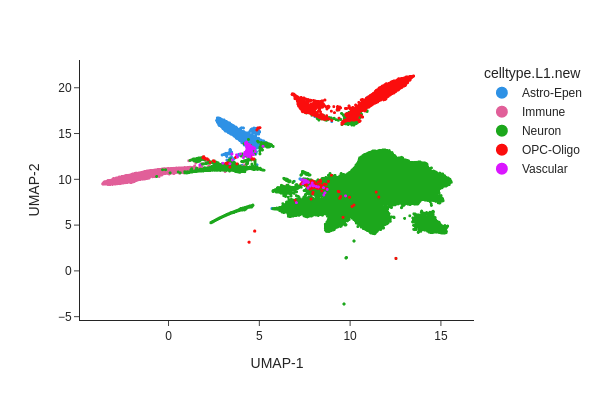

In [12]:
snap.pl.umap(adata, color="celltype.L1.new", interactive=False,  marker_size=3)


In [13]:
adata.write_h5ad("/data2st1/junyi/output/mouse_brain_dar.h5ad")

... storing 'celltype.L1.new' as categorical


In [14]:
from snapatac2._snapatac2 import read_motifs, PyDNAMotif

def cis_bp_mouse(unique: bool = True , path="data/motifdb/Mus_musculus.meme") -> list[PyDNAMotif]:
    motifs = read_motifs(path)
    for motif in motifs:
        motif.name = motif.id.split('+')[0]
    if unique:
        unique_motifs = {}
        for motif in motifs:
            name = motif.name
            if (
                    name not in unique_motifs or 
                    unique_motifs[name].info_content() < motif.info_content()
               ):
               unique_motifs[name] = motif
        motifs = list(unique_motifs.values())
    return motifs


In [15]:
#celltypes = adata.obs["celltype.L1.tab"].unique()
regions = ['AMY','HIP','PFC']
celltypes = ['OPC-Oligo', 'Immune','Astro-Epen','Vascular']
print(celltypes)
print(regions)

['OPC-Oligo', 'Immune', 'Astro-Epen', 'Vascular']
['AMY', 'HIP', 'PFC']


In [20]:
# Column to use for stratification
stratify_column = 'sample'

# Number of cells to sample from each group
n_samples_per_group = 2000

# Perform stratified sampling
sampled_indices = (
    adata.obs
    .groupby(stratify_column, group_keys=False)
    .apply(lambda x: x.sample(min(n_samples_per_group, len(x))))
    .index
)


/tmp/ipykernel_2089906/1039730475.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [22]:
region = 'ALL'
celltype = 'ALL'
base_name = f"{region}_{celltype}"
adata_AMY_neuron  = adata[sampled_indices, :]

adata_AMY_neuron.obs['expriment'] = adata_AMY_neuron.obs['sample'].str[:2]

/tmp/ipykernel_2089906/4130967597.py:6: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



In [ ]:


%time snap.tl.macs3(adata_AMY_neuron, groupby='celltype.L1.new')
%time peaks = snap.tl.merge_peaks(adata_AMY_neuron.uns['macs3'], snap.genome.GRCm39)

%time peak_mat = snap.pp.make_peak_matrix(adata_AMY_neuron, use_rep=peaks['Peaks'])

peak_mat.layers['raw'] = peak_mat.X.copy()
sc.pp.normalize_total(peak_mat)
sc.pp.log1p(peak_mat)
%time
sc.tl.rank_genes_groups(peak_mat, groupby='expriment', method='wilcoxon',pts=True)
peak_mat.obsm['X_umap'] = adata_AMY_neuron.obsm['X_umap']
peak_mat.write(f"output/motif/{base_name}.h5ads")


2025-03-19 13:15:43 - INFO - Exporting fragments...
2025-03-19 13:21:38 - INFO - Calling peaks...
 80%|████████  | 4/5 [06:28<01:38, 98.46s/it] 

In [ ]:
sc.pl.umap(peak_mat, color='expriment', size=50,save=f"{base_name}_sample_umap.png")
df = sc.get.rank_genes_groups_df(peak_mat, group='MC', key='rank_genes_groups',pval_cutoff=0.05)
df.to_csv(f"output/motif/{region}_{celltype}_MC_wilcoxon.csv")
#df.to_csv("output/AMY_neuron_MC_wilcoxon.csv")
#df.sort_values('logfoldchanges',ascending=False).names.str.split(r'[-:]', expand=True).to_csv("output/AMY_neuron_MC_wilcoxon.bed",sep='\t', header=False, index=False) 
sc.pl.umap(peak_mat, color=df.sort_values('logfoldchanges',ascending=False).head(10).names, size=50,save=f"{base_name}_region_umap.png")
df_mw = sc.get.rank_genes_groups_df(peak_mat, group='MW', key='rank_genes_groups',pval_cutoff=0.05)
df_mw.to_csv(f"output/motif/{region}_{celltype}_MW_wilcoxon.csv")
# %%time
# marker_peaks = snap.tl.marker_regions(peak_mat, groupby='expriment', pvalue=0.05)

# marker_peaks = {"MC": df[df.logfoldchanges>0.1].set_index('names').index,"MW":df_mw[df_mw.logfoldchanges>0.1].set_index('names').index}

# try:
#     motifs = snap.tl.motif_enrichment(
#         motifs=cis_bp_mouse(unique=True,path="data/motifdb/Mus_musculus.meme"),
#         regions=marker_peaks,
#         genome_fasta=snap.genome.GRCm39,
#     )

#     motifs['MC'].write_csv(f"output/motif/{region}_{celltype}_MC_cisbp_motif.csv")
#     fig = snap.pl.motif_enrichment(motifs, max_fdr=0.0001, height=4000, interactive=False)
#     with open(f"output/motif/{base_name}_MC_cisbp_motif.png", 'wb') as f:
#         f.write(fig.data)  # Assuming 'im.data' contains the image data
# except Exception as e:
#     print(e)    
#     print(f"Error in {region}_{celltype}_MC_cisbp_motif")

# try:

#     motifs = snap.tl.motif_enrichment(
#         motifs=cis_bp_mouse(unique=True,path="data/motifdb/uniprobe_mouse.meme"),
#         regions=marker_peaks,
#         genome_fasta=snap.genome.GRCm39,
#     )

#     fig = snap.pl.motif_enrichment(motifs, max_fdr=0.0001, height=4000, interactive=False)
#     with open(f"output/motif/{base_name}_MC_uniprod_motif.png", 'wb') as f:
#         f.write(fig.data)  # Assuming 'im.data' contains the image data

#     #motifs['MC'].write_csv("output/motif/AMY_neuron_MC_motif_uniprot.csv")
#     motifs['MC'].write_csv(f"output/motif/{region}_{celltype}_MC_motif_uniprot.csv")
# except Exception as e:
#     print(e)    
#     print(f"Error in {region}_{celltype}_MC_motif_uniprot")

In [ ]:
import h5py
file_name = "/data2st1/junyi/output/motif/peaks.h5"
df = peaks
with h5py.File(file_name, "w") as f:
    # Save the data (excluding the row names column)
    f.create_dataset("data", data=df.drop("Peaks").to_numpy())
    
    # Save the row names
    f.create_dataset("row_names", data=np.array(df["Peaks"].to_list(), dtype="S"))
    
    # Save the column names
    f.create_dataset("col_names", data=np.array(df.columns[1:], dtype="S"))


In [ ]:
peaks.to_hdf('/data2st1/junyi/output/motif/ALL_all_peaks.h5', key="peaks", mode="w")


In [ ]:
for region in regions:
    for celltype in celltypes:
        #region = 'PFC'
        #celltype = 'Neuron'
        base_name = f"{region}_{celltype}"
        adata_AMY_neuron = adata[(adata.obs['sample'].str.contains(region)) & (adata.obs['celltype.L1.new'].str.contains(celltype)) ].copy()

        adata_AMY_neuron.obs['expriment'] = adata_AMY_neuron.obs['sample'].str[:2]

        snap.pl.umap(adata_AMY_neuron, color="sample", interactive=False,  marker_size=3)

        %time snap.tl.macs3(adata_AMY_neuron, groupby='expriment')

        adata_AMY_neuron
        %time peaks = snap.tl.merge_peaks(adata_AMY_neuron.uns['macs3'], snap.genome.GRCm39)

        %time peak_mat = snap.pp.make_peak_matrix(adata_AMY_neuron, use_rep=peaks['Peaks'])

        peak_mat.layers['raw'] = peak_mat.X.copy()
        sc.pp.normalize_total(peak_mat)
        sc.pp.log1p(peak_mat)
        %time
        sc.tl.rank_genes_groups(peak_mat, groupby='expriment', method='wilcoxon',pts=True)
        peak_mat.obsm['X_umap'] = adata_AMY_neuron.obsm['X_umap']
        peak_mat.write(f"output/motif/{base_name}.h5ads")
        sc.pl.umap(peak_mat, color='expriment', size=50,save=f"{base_name}_sample_umap.png")
        df = sc.get.rank_genes_groups_df(peak_mat, group='MC', key='rank_genes_groups',pval_cutoff=0.05)
        if df.empty:
            print(f"No dar detected {region}_{celltype}")
            continue
        df.to_csv(f"output/motif/{region}_{celltype}_MC_wilcoxon.csv")
        #df.to_csv("output/AMY_neuron_MC_wilcoxon.csv")
        #df.sort_values('logfoldchanges',ascending=False).names.str.split(r'[-:]', expand=True).to_csv("output/AMY_neuron_MC_wilcoxon.bed",sep='\t', header=False, index=False) 
        sc.pl.umap(peak_mat, color=df.sort_values('logfoldchanges',ascending=False).head(10).names, size=50,save=f"{base_name}_region_umap.png")
        df_mw = sc.get.rank_genes_groups_df(peak_mat, group='MW', key='rank_genes_groups',pval_cutoff=0.05)
        df_mw.to_csv(f"output/motif/{region}_{celltype}_MW_wilcoxon.csv")
        # %%time
        # marker_peaks = snap.tl.marker_regions(peak_mat, groupby='expriment', pvalue=0.05)

        marker_peaks = {"MC": df[df.logfoldchanges>0.1].set_index('names').index,"MW":df_mw[df_mw.logfoldchanges>0.1].set_index('names').index}

        try:
            motifs = snap.tl.motif_enrichment(
                motifs=cis_bp_mouse(unique=True,path="data/motifdb/Mus_musculus.meme"),
                regions=marker_peaks,
                genome_fasta=snap.genome.GRCm39,
            )

            motifs['MC'].write_csv(f"output/motif/{region}_{celltype}_MC_cisbp_motif.csv")
            fig = snap.pl.motif_enrichment(motifs, max_fdr=0.0001, height=4000, interactive=False)
            with open(f"output/motif/{base_name}_MC_cisbp_motif.png", 'wb') as f:
                f.write(fig.data)  # Assuming 'im.data' contains the image data
        except Exception as e:
            print(e)    
            print(f"Error in {region}_{celltype}_MC_cisbp_motif")

        try:

            motifs = snap.tl.motif_enrichment(
                motifs=cis_bp_mouse(unique=True,path="data/motifdb/uniprobe_mouse.meme"),
                regions=marker_peaks,
                genome_fasta=snap.genome.GRCm39,
            )

            fig = snap.pl.motif_enrichment(motifs, max_fdr=0.0001, height=4000, interactive=False)
            with open(f"output/motif/{base_name}_MC_uniprod_motif.png", 'wb') as f:
                f.write(fig.data)  # Assuming 'im.data' contains the image data

            #motifs['MC'].write_csv("output/motif/AMY_neuron_MC_motif_uniprot.csv")
            motifs['MC'].write_csv(f"output/motif/{region}_{celltype}_MC_motif_uniprot.csv")
        except Exception as e:
            print(e)    
            print(f"Error in {region}_{celltype}_MC_motif_uniprot")

In [ ]:
snap.pl.umap(adata_AMY_neuron, color="sample", interactive=True,  marker_size=3)


In [ ]:
adata_AMY_neuron.obs['interested'] = 'Other'
condition = (adata_AMY_neuron.obsm['X_umap'][:, 0] > 13.5) & (adata_AMY_neuron.obsm['X_umap'][:, 1] < 6.2)
adata_AMY_neuron.obs.loc[condition,'interested'] = 'Interested'


In [ ]:
snap.pl.umap(adata_AMY_neuron, color="interested", interactive=True,  marker_size=3)


In [ ]:
%time snap.tl.macs3(adata_AMY_neuron, groupby='interested')
%time peaks = snap.tl.merge_peaks(adata_AMY_neuron.uns['macs3'], snap.genome.GRCm39)
peak_mat = snap.pp.make_peak_matrix(adata_AMY_neuron, use_rep=peaks['Peaks'])

sc.tl.rank_genes_groups(peak_mat, groupby='interested', method='wilcoxon',pts=True)
peak_mat.obsm['X_umap'] = adata_AMY_neuron.obsm['X_umap']
peak_mat.write(f"output/motif/{base_name}_neuron_subtypes.h5ads")


In [ ]:
df = sc.get.rank_genes_groups_df(peak_mat, group='Interested', key='rank_genes_groups',pval_cutoff=1)


In [ ]:
df

In [ ]:
adata_gene = snap.pp.make_gene_matrix(adata,gene_anno=snap.genome.GRCm39)


In [ ]:
adata

In [ ]:
for key in adata.obsm.keys():
    adata_gene.obsm[key] = adata.obsm[key]

In [ ]:
adata_gene.write("output/mouse_brain_gene.h5ads")

In [ ]:
adata